# Generate a Mock Dataset

Generate a simulated TF dataset as follows:

* Merge the iron photometric + spectroscopic catalogs with the SGA2020 catalog.
* Apply all photometric corrections used in the TF analysis.
* Cross-match with one of the BGS mocks.
* Apply photometric and morphological cuts used in the PV survey for late-type galaxies.
* Generate mock rotational velocities using an inverted TFR best fit from the data.
* Generate mock TFR distances. 

In [1]:
import os
import shutil
import h5py
import fitsio
import pickle
import healpy as hp
import pandas as pd
import numpy as np
import scipy as sp

from csaps import csaps
from scipy.interpolate import PchipInterpolator, UnivariateSpline
from scipy.stats import binned_statistic
from scipy.odr import ODR, Model, RealData
from scipy.spatial import KDTree

#- Global file path for PV analysis.
#  Set to the NERSC folder /global/cfs/cdirs/desi/science/td/pv by default.
#  Set it to something else if working offline.
pvpath = '/global/cfs/cdirs/desi/science/td/pv'
mockpath = os.path.join(pvpath, 'mocks')
tfmockpath = os.path.join(mockpath, 'TF_mocks')

from corner import corner
from hyperfit.linfit import LinFit

#- Path to TF_mocks: code for Blanton's k-corrections.
import sys
sys.path.append(tfmockpath)
import TF_photoCorrect as tfpc
from line_fits import hyperfit_line_multi

from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18, FlatLambdaCDM, units
from astropy.coordinates import SkyCoord, Distance

from tqdm import tqdm
from glob import glob

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

## Iron Data + SGA Catalog

Follow the procedure used in FP mock generation: read in iron data relevant for the TFR for cross-matching to the BGS mocks, producing a simulated set with realistic galaxy observables.

Here we merge the fullsweep and iron specprod catalogs to reproduce cuts when cross-matching with the mocks.

As a final step, get any missing SGA data directly from the SGA 2020 catalog.

In [3]:
#- Read in the iron fullsweep and specprod catalogs.
sw_keys = ['targetid', 'survey', 'program', 'healpix', 'target_ra', 'target_dec',
           'z', 'zerr', 'zwarn', 'inbasiccuts', 'has_corrupt_phot',
           'mag_g', 'mag_r', 'mag_z',
           'morphtype', 'sersic', 'BA_ratio',
           'circ_radius', 'circ_radius_err', 'uncor_radius', 'SGA_id', 'radius_SB25']

ironsweep = os.path.join(pvpath, 'redshift_data/Y1/iron_fullsweep_catalogue_z012.csv')
iron = pd.read_csv(ironsweep, usecols=sw_keys)

#- Read in the spectroscopic production table generated by Caitlin Ross.
sp_keys = ['targetid', 'survey', 'program', 'healpix',
           'mag_err_g', 'mag_err_r', 'mag_err_z', 
           'deltachi2']

ironspec = os.path.join(pvpath, 'redshift_data/Y1/specprod_iron_healpix_z015.csv')
ironsp = pd.read_csv(ironspec, usecols=sp_keys)

#- Cross-match the catalogs.
iron = pd.merge(iron, ironsp, 
                left_on=['targetid', 'survey', 'program', 'healpix'],
                right_on=['targetid', 'survey', 'program', 'healpix'], how='inner')

#- Object selection from the spectro pipeline:
#  1. Valid SGA ID, which implicitly enforces a size selection.
#  2. Delta-chi2 > 25.
#  3. No redrock warnings.
select = (iron['SGA_id'] > 0) & \
         (iron['deltachi2'] >= 25) & \
         (iron['zwarn'] == 0)

iron = iron.drop(iron[~select].index)

#- Read the SGA catalog and match on SGA_ID.
#  This is needed to access R_26 and other quantities at the mag 26 isophote.
sgafile = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'
sgacat = Table.read(sgafile, 'ELLIPSE')
sgacat.rename_column('SGA_ID', 'SGA_id')
sgacat.rename_column('RA', 'SGA_ra')
sgacat.rename_column('DEC', 'SGA_dec')
sgacat = sgacat['SGA_ra', 'SGA_dec', 'SGA_id', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR'].to_pandas()
sgacat = sgacat.drop(sgacat[sgacat['R_MAG_SB26'] < 0].index)

iron = pd.merge(iron, sgacat, how='inner', on=['SGA_id'])

In [4]:
#- Drop NaN
iron = iron.dropna()
iron

,survey,program,healpix,targetid,target_dec,target_ra,z,zerr,zwarn,morphtype,...,mag_err_r,SGA_ra,SGA_dec,D26,G_MAG_SB26,G_MAG_SB26_ERR,R_MAG_SB26,R_MAG_SB26_ERR,Z_MAG_SB26,Z_MAG_SB26_ERR
0,sv1,bright,34723,39627082556248187,-30.586432,58.890261,0.093327,1.755050e-05,0,SER,...,0.000430,58.890261,-30.586432,0.575315,17.063408,0.034668,16.134380,0.038069,15.478448,0.039409
1,sv1,bright,34725,39627082589804885,-30.509964,61.244826,0.058229,3.289745e-06,0,SER,...,0.000833,61.244826,-30.509964,0.398020,17.159575,0.005541,16.691721,0.005926,16.403215,0.006768
2,sv1,bright,34703,39627082593998226,-30.408004,61.518464,0.059050,2.278493e-06,0,SER,...,0.000355,61.518464,-30.408004,0.998481,16.092411,0.024773,15.328482,0.026500,14.777832,0.026026
3,sv1,bright,34729,39627087765574578,-30.251105,58.278362,0.081022,1.363088e-05,0,SER,...,0.001176,58.278362,-30.251105,0.427528,18.176348,0.028036,17.460354,0.029271,16.949606,0.031180
4,sv1,bright,34729,39627087773962063,-30.188369,58.780902,0.096937,1.941603e-05,0,SER,...,0.000785,58.780902,-30.188369,0.648811,17.540487,0.039971,16.529564,0.041773,15.713690,0.042567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102514,main,dark,7975,2852649649045504,72.895711,131.867353,0.011291,7.328162e-06,0,DEV,...,0.000785,131.867353,72.895711,0.841495,16.188450,0.005690,15.252360,0.006012,14.736343,0.008489
102515,main,dark,7973,2852649653239808,72.926464,133.218536,0.012603,7.566643e-07,0,DEV,...,0.000462,133.218536,72.926464,1.141312,15.233910,0.016896,14.147840,0.015995,13.483636,0.021117
102516,main,dark,8034,2852673590132736,76.634771,140.593982,0.076971,4.815062e-06,0,SER,...,0.001131,140.593982,76.634771,0.515602,16.521830,0.005591,15.891319,0.005790,15.526414,0.006989
102517,sv3,bright,11604,39633456283519525,66.170195,266.658931,0.117068,1.531648e-05,0,SER,...,0.001742,266.658931,66.170195,0.686332,16.746572,0.019684,16.290340,0.016576,16.699310,0.030471


### Keep only Galaxy Centers

The iron catalog may include some off-axis measurements of SGA galaxies that pass the spectroscopic cuts. Remove them with a cone-angle cut, comparing the SGA centers (from Tractor) to the target RA, Dec in DESI. The cut is

$$
\frac{\angle(\mathbf{r}_\mathrm{SGA}, \mathbf{r}_\mathrm{fiber})}{D_{26}/2} < 0.1
$$

See details in Kelly's [SGA selection notebook for iron](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/iron_rot_vel.ipynb).

Note that requiring a nonzero $m_{r,\mathrm{SB_{26}}}$ may remove all spectra not measured on galaxy centers, making this cut redundant.

In [5]:
coords_sga = SkyCoord(ra=iron['SGA_ra'], dec=iron['SGA_dec'], unit='degree')
coords_iron = SkyCoord(ra=iron['target_ra'], dec=iron['target_dec'], unit='degree')
sep2d = coords_iron.separation(coords_sga)
select = (2*sep2d.to_value('arcmin') / iron['D26']) < 0.1

iron = iron.drop(iron[~select].index)

In [6]:
iron

,survey,program,healpix,targetid,target_dec,target_ra,z,zerr,zwarn,morphtype,...,mag_err_r,SGA_ra,SGA_dec,D26,G_MAG_SB26,G_MAG_SB26_ERR,R_MAG_SB26,R_MAG_SB26_ERR,Z_MAG_SB26,Z_MAG_SB26_ERR
0,sv1,bright,34723,39627082556248187,-30.586432,58.890261,0.093327,1.755050e-05,0,SER,...,0.000430,58.890261,-30.586432,0.575315,17.063408,0.034668,16.134380,0.038069,15.478448,0.039409
1,sv1,bright,34725,39627082589804885,-30.509964,61.244826,0.058229,3.289745e-06,0,SER,...,0.000833,61.244826,-30.509964,0.398020,17.159575,0.005541,16.691721,0.005926,16.403215,0.006768
2,sv1,bright,34703,39627082593998226,-30.408004,61.518464,0.059050,2.278493e-06,0,SER,...,0.000355,61.518464,-30.408004,0.998481,16.092411,0.024773,15.328482,0.026500,14.777832,0.026026
3,sv1,bright,34729,39627087765574578,-30.251105,58.278362,0.081022,1.363088e-05,0,SER,...,0.001176,58.278362,-30.251105,0.427528,18.176348,0.028036,17.460354,0.029271,16.949606,0.031180
4,sv1,bright,34729,39627087773962063,-30.188369,58.780902,0.096937,1.941603e-05,0,SER,...,0.000785,58.780902,-30.188369,0.648811,17.540487,0.039971,16.529564,0.041773,15.713690,0.042567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102514,main,dark,7975,2852649649045504,72.895711,131.867353,0.011291,7.328162e-06,0,DEV,...,0.000785,131.867353,72.895711,0.841495,16.188450,0.005690,15.252360,0.006012,14.736343,0.008489
102515,main,dark,7973,2852649653239808,72.926464,133.218536,0.012603,7.566643e-07,0,DEV,...,0.000462,133.218536,72.926464,1.141312,15.233910,0.016896,14.147840,0.015995,13.483636,0.021117
102516,main,dark,8034,2852673590132736,76.634771,140.593982,0.076971,4.815062e-06,0,SER,...,0.001131,140.593982,76.634771,0.515602,16.521830,0.005591,15.891319,0.005790,15.526414,0.006989
102517,sv3,bright,11604,39633456283519525,66.170195,266.658931,0.117068,1.531648e-05,0,SER,...,0.001742,266.658931,66.170195,0.686332,16.746572,0.019684,16.290340,0.016576,16.699310,0.030471


## Apply Dust and K-corrections

There are four photometric corrections that need to be applied.

1. N vs. S imaging catalog photometric systematics.
2. $k$-corrections to $z=0.1$.
3. Global Milky Way dust corrections using the maps from Zhou+, 2024.
4. Per-galaxy internal dust corrections based on the galaxies' inclination angles.

The corrections, applied to the $r$-band magnitudes, are summed as

$$
A_\mathrm{sys} + A_k + A_\mathrm{MW} + A_\mathrm{dust}
$$

### Imaging Systematics

In [7]:
#- Apply imaging survey systematics: compute photometric system (N or S)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
c = SkyCoord(iron['target_ra'], iron['target_dec'], unit='degree')
isnorth = (c.galactic.b > 0) & (iron['target_dec'] > 32.375)
iron['photsys'] = 'S'
iron.loc[isnorth, 'photsys'] = 'N'

#- Adjust northern photometry to DECaLS
Asys, Asys_err = tfpc.BASS_corr(iron['photsys'])

### K Correction

In [8]:
#- This is based on the kcorrect package by Blanton (https://kcorrect.readthedocs.io/)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
select = iron['z'] > 0

kc = tfpc.k_corr(iron['z'][select], 
                [iron['G_MAG_SB26'][select],     iron['R_MAG_SB26'][select],     iron['Z_MAG_SB26'][select]], 
                [iron['G_MAG_SB26_ERR'][select], iron['R_MAG_SB26_ERR'][select], iron['Z_MAG_SB26_ERR'][select]], 
                z_corr=0.1)

Ak = np.zeros((len(iron), 3))
Ak[select] = kc

### MW Dust Correction

In [9]:
#- Compute MW dust corrections
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
dustmap = '/global/cfs/cdirs/desi/public/papers/mws/desi_dust/y2/v1/maps/desi_dust_gr_512.fits'
ebv = Table.read(dustmap)
Adust, Adust_err = tfpc.MW_dust(iron['target_ra'].values, iron['target_dec'].values, ebv)

#- Mask out NaNs
for i, band in enumerate('grz'):
    isnan_gal = np.isnan(Adust[i])
    if np.any(isnan_gal):
        logging.info(f'Removing NaN for MW dust correction, band {band}')
        Adust[i][isnan_gal] = 0
        Adust_err[i][isnan_gal] = 0

/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


### Apply MW, K-Correction, and Imaging Systematics Corrections Prior to Internal Dust Correction

In [10]:
#- Apply MW dust, k-corrections, and photometric systematic corrections to the data.
for i, band in enumerate('GRZ'):
    iron[f'{band}_MAG_SB26_tmp'] = iron[f'{band}_MAG_SB26'] - Adust[i] + Asys + Ak[:,i]
    iron[f'{band}_MAG_SB26_ERR_tmp'] = np.sqrt(iron[f'{band}_MAG_SB26_ERR']**2 + Adust_err[i]**2 + Asys_err**2)

### Internal Dust Correction 

Correct m_r for the internal galactic dust, assuming that as we look through higher inclinations we're viewing the galaxy through its dust lanes. Details in [this notebook by Kelly](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_iron_internal-dustCorr.ipynb).

Best fit:     [-1.37475514  0.75256222]
uncertainty:  [0.08632504 0.04738354]


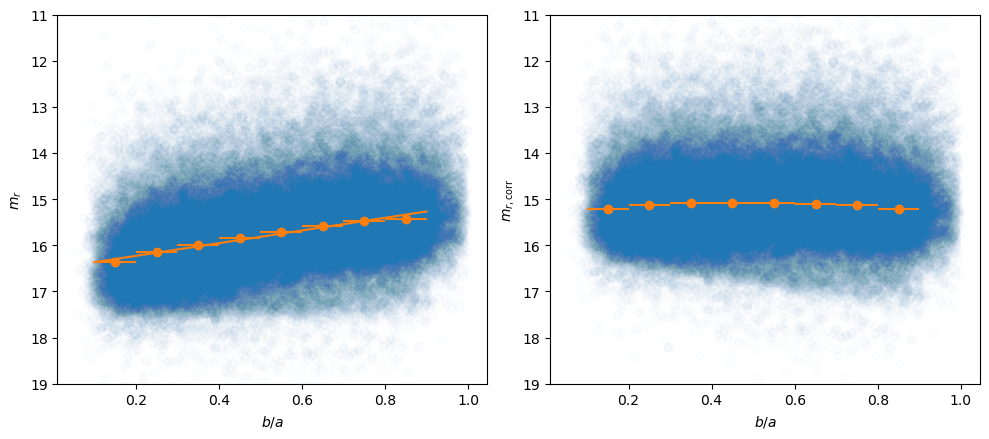

In [11]:
#- Kelly applies an empirical fit to the internal dust in each galaxy. Steps:
#   1. Apply "known" corrections (k-correction, MW dust).
#   2. Fit m_r_corr (corrected) vs spiral b/a
#   3. Zero out this linear dependence.

#- Set up a binned data set and perform the fit
ba_bins = np.arange(0.1,1,0.1)
ba = 0.5*(ba_bins[1:] + ba_bins[:-1])
ba_err = 0.5*np.diff(ba_bins)
m_r_median = np.median(iron['R_MAG_SB26_tmp'])
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='std', bins=ba_bins)
m_r_err /= np.sqrt(n_bin)

linear_fit = lambda coeff, x: coeff[0]*x + coeff[1]
model = Model(linear_fit)
data = RealData(ba, m_r - m_r_median, sx=ba_err, sy=m_r_err)
odr = ODR(data, model, beta0=[1, 1])

result = odr.run()
coeff = result.beta
coeff_err = result.sd_beta
print('Best fit:    ', coeff)
print('uncertainty: ', coeff_err)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True)#, sharey=True)
ax = axes[0]
ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], alpha=0.01)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:orange')
ax.plot(ba_bins, coeff[0]*ba_bins + coeff[1] + m_r_median, color='tab:orange')
ax.set(ylim=(19, 11),
       ylabel='$m_{r}$',
       xlabel='$b/a$');

#- Compute the internal dust correction
A_int, A_int_err = tfpc.internal_dust(iron['BA_ratio'].values, coeff, coeff_err)

ax = axes[1]
ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, alpha=0.01)
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, statistic='median', bins=ba_bins)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:orange')
ax.set(ylim=(19, 11),
       ylabel='$m_{r,\mathrm{corr}}$',
       xlabel='$b/a$')

# fig.savefig('tfr_mock_internal_dust_correction.png', dpi=150);

#- Update the r-band magnitudes
iron['R_MAG_SB26_CORR'] = iron['R_MAG_SB26_tmp'] - A_int
iron['R_MAG_SB26_ERR_CORR'] = np.sqrt(iron['R_MAG_SB26_ERR_tmp']**2 + A_int_err**2)

## BGS Mock Catalog

Read in one of the mock catalog files and cross-match to iron.

In [12]:
#- There are 25 BGS mocks and (usually) 27 realizations per mock.
#  Pick one, it doesn't matter which.
mockfiles = sorted(glob(os.path.join(pvpath, 'mocks/BGS_base/v0.5/iron/BGS_PV_AbacusSummit_base*.hdf5')))
mockfile = mockfiles[0]

In [13]:
#- Fill the catalog as a dictionary and convert to a Pandas table.
#  Here we follow the I/O from the FP generator (thanks Cullan).
mock = {}
with h5py.File(mockfile, 'r') as f:
    for key in f.keys():
        if key == 'vel':
            #- Pack the galaxy velocities into labeled vx, vy, vz
            mock['vx'] = f['vel'][:,0]
            mock['vy'] = f['vel'][:,1]
            mock['vz'] = f['vel'][:,2]
        else:
            mock[key] = f[key][()]

        # convert strings to unicode
        if key == 'survey' or key == 'program':
            mock[key] = mock[key].astype('U')

    #- Convert to a pandas table
    mock = pd.DataFrame.from_dict(mock)

    #- Merge with iron on 4 keywords
    mock = mock.merge(iron, how='inner', on=['targetid', 'survey', 'program', 'healpix'])

In [14]:
mock.keys()

Index(['Y1_COMP', 'Y3_COMP', 'Y5', 'abs_mag', 'app_mag', 'col', 'col_obs',
       'dec', 'halo_mass', 'healpix', 'is_cen', 'is_res', 'program', 'ra',
       'survey', 'targetid', 'vx', 'vy', 'vz', 'zcos', 'zobs', 'target_dec',
       'target_ra', 'z', 'zerr', 'zwarn', 'morphtype', 'sersic', 'mag_g',
       'mag_r', 'mag_z', 'uncor_radius', 'BA_ratio', 'circ_radius',
       'circ_radius_err', 'SGA_id', 'radius_SB25', 'inbasiccuts',
       'has_corrupt_phot', 'deltachi2', 'mag_err_g', 'mag_err_z', 'mag_err_r',
       'SGA_ra', 'SGA_dec', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR',
       'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR',
       'photsys', 'G_MAG_SB26_tmp', 'G_MAG_SB26_ERR_tmp', 'R_MAG_SB26_tmp',
       'R_MAG_SB26_ERR_tmp', 'Z_MAG_SB26_tmp', 'Z_MAG_SB26_ERR_tmp',
       'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR'],
      dtype='object')

In [15]:
mock

,Y1_COMP,Y3_COMP,Y5,abs_mag,app_mag,col,col_obs,dec,halo_mass,healpix,...,Z_MAG_SB26_ERR,photsys,G_MAG_SB26_tmp,G_MAG_SB26_ERR_tmp,R_MAG_SB26_tmp,R_MAG_SB26_ERR_tmp,Z_MAG_SB26_tmp,Z_MAG_SB26_ERR_tmp,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR
0,0.924658,0.924658,True,-21.681203,15.980773,0.960208,0.985633,-3.081162,1.706458e+13,6254,...,0.011305,S,16.851769,0.028381,15.874040,0.020752,15.189850,0.015158,15.128089,0.051232
1,0.965035,0.951049,True,-21.595476,16.066228,1.012123,1.038378,-2.078191,3.587126e+13,5691,...,0.017739,N,16.952461,0.051406,15.946439,0.038826,15.399243,0.031930,15.366448,0.053234
2,0.992647,0.992647,True,-21.364202,16.298602,0.599409,0.613639,-2.168459,7.139241e+12,26335,...,0.016622,S,16.835827,0.032104,16.232840,0.023519,15.743264,0.020170,16.076251,0.025492
3,1.000000,0.954248,True,-21.240528,16.417812,0.773583,0.791558,-2.216520,7.921710e+12,31674,...,0.011959,S,17.191625,0.049308,16.406774,0.034322,15.799429,0.021647,15.903267,0.046665
4,0.737226,0.956204,True,-21.212804,16.447380,0.955246,0.980329,-2.348961,2.636352e+12,9054,...,0.019345,S,17.402140,0.029685,16.421736,0.023609,15.757021,0.021548,15.787319,0.046307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477752,0.993939,1.000000,True,-21.197265,16.464802,0.812983,0.832798,-7.939655,3.937655e+12,25831,...,0.039442,S,17.453111,0.044118,16.598413,0.040451,15.990558,0.041225,15.741797,0.067302
477753,0.000000,0.976048,True,-21.314300,16.327281,0.716685,0.731616,-2.837005,4.937360e+12,26261,...,0.024686,S,16.972424,0.034001,16.252165,0.030003,15.702043,0.026502,15.498473,0.056035
477754,0.000000,0.960000,True,-22.657113,15.009431,0.983262,1.009748,-3.740560,1.119142e+14,6099,...,0.032304,N,16.277540,NaN,15.253113,NaN,14.820637,NaN,15.152228,NaN
477755,0.000000,0.965517,True,-21.439198,16.219219,0.914962,0.938560,-9.626423,1.245539e+14,18072,...,0.022852,S,17.236936,NaN,16.307480,NaN,15.669558,NaN,16.080355,NaN


### Apply TF Selection Cuts

Here apply the late-type galaxy cuts defined in *Target Selection for the DESI Peculiar Velocity Survey*, C. Saulder+, MNRAS 525:1106, 2023. Note that several cuts are the complement of the early-type cuts for the FP sample.

In [16]:
mock_selection = {
    'basic cuts' : 0,
    'z < 0.1' : 0,
    'b/a < cos(25°)' : 0,
    'morphtype' : 0,
    'NaN' : 0
}

#- Apply target selection
print(f'Size of cross-matched iron+mock catalog ..{len(mock):.>20d}')

#- Drop data that doesn't pass the photometric cuts
select = (mock['inbasiccuts'] == 0) | (mock['has_corrupt_phot'] == 1)
mock = mock.drop(mock[select].index)
mock_selection['basic cuts'] = len(mock)
print(f'Size after photometric cuts .........{len(mock):.>20d}')

#- Redshift range cut: remove?
select = mock['zobs'] <= 0.1
mock = mock[select]
mock_selection['z < 0.1'] = len(mock)
print(f'Redshift selection: z < 0.1 {len(mock):.>29d}')

#- B/A ratio cut:
select = mock['BA_ratio'] < np.cos(np.radians(25))
mock = mock[select]
mock_selection['b/a < cos(25°)'] = len(mock)
print(f'Ratio b/a < cos(25 deg) .............{len(mock):.>20d}')

#- Morphology cuts:
select = (mock['morphtype'] == 'EXP') | ((mock['morphtype'] == 'SER') & (mock['sersic'] <= 2))
mock = mock[select]
mock_selection['morphtype'] = len(mock)
print(f'Morphology cuts: ....................{len(mock):.>20d}')

#- Drop any rows with NaN
mock = mock.dropna()
mock_selection['NaN'] = len(mock)
print(f'Drop NaN ............................{len(mock):.>20d}')

Size of cross-matched iron+mock catalog ................477757
Size after photometric cuts .......................477567
Redshift selection: z < 0.1 .......................455389
Ratio b/a < cos(25 deg) ...........................439935
Morphology cuts: ..................................237686
Drop NaN ..........................................203283


/tmp/ipykernel_55294/1003090540.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha='right')


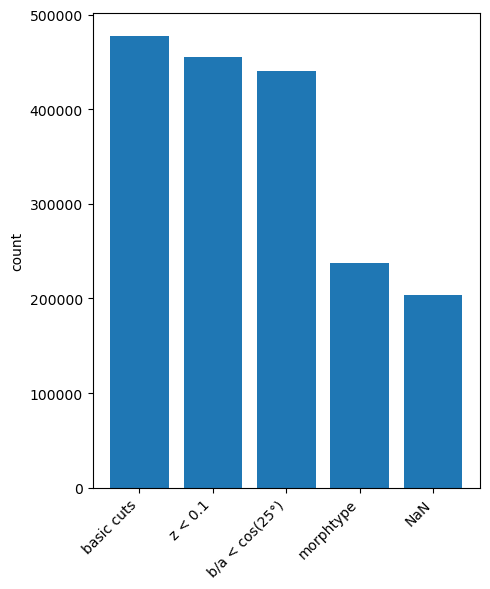

In [17]:
names = list(mock_selection.keys())
values = list(mock_selection.values())

fig, ax = plt.subplots(1, 1, figsize=(5,6), tight_layout=True)
bars = ax.bar(names, values)
ax.set_xticklabels(names, rotation=45, ha='right')
# ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);
# fig.savefig('tfr_mock_cuts.png', dpi=150)

## Compute TFR Quantities

Assign a rotational velocity using the data. Then use this to infer $M_r$ using the calibrated TFR.

### Set up the Cosmology

Use a flat-$\Lambda$CDM fiducial cosmology with $H_0\equiv100$ km/s/Mpc and $\Omega_m=0.3151$.

In [18]:
cosmology = FlatLambdaCDM(H0=100, Om0=0.3151)

### Current Y1 TFR Best Fit

TF Y1 best-fit parameters and covariances, corresponding to v8 of the TF Y1 catalog. This comes from the TFR calibration using 7 galaxy clusters (2025-03-28) using Vmax weights to account for the galaxy size function. The TFR fit is

$$
M_r = a \log_{10}{\left(\frac{V_\mathrm{rot}}{V_0}\right)} + b_{0\mathrm{pt}}
$$

with intrinsic scatter $\sigma$ along the magnitude axis. See this [notebook](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_Y1_cluster_calibration_AnthonyUpdates_weightsVmax-1_KAD.ipynb) in the [DESI_SGA/TF/Y1](https://github.com/DESI-UR/DESI_SGA/tree/master/TF/Y1) GitHub repo.

The parameter vector includes the TFR slope $a$, global zero point $b_{0\text{pt}}$, calibration cluster intercepts $\{b_i\}$, and intrinsic scatter $\sigma$.

In [19]:
with open('../cov_ab_iron_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_Anthony_weightsVmax-1_KAD-20250328.pickle', 'rb') as tfr_file:
    cov_ab, tfr_samples, logV0 = pickle.load(tfr_file)

# Extract all best-fit parameters, including individual cluster intercepts.
a, b0pt, b1, b2, b3, b4, b5, b6, b7, sigma = [np.median(tfr_samples[i]) for i in range(10)]

# Store TF best-fit parameters.
tf_par = np.asarray([a, b0pt, sigma])

# Store the covariance of the intercept, slope, and intrinsic scatter.
mask = np.zeros_like(cov_ab, dtype=bool)
mask[:2, :2] = mask[:2, 9] = mask[9, :2] = mask[9,9] = True
tf_cov = cov_ab[mask].reshape(3,3)

### Current TFR Catalog

Read in the TFR catalog to sample uncertainties in $V_\mathrm{rot}$.

In [20]:
tfrcatfile = os.path.join(pvpath, 'tfgalaxies/Y1/DESI-DR1_TF_pv_cat_v8.fits')
tfrcat = Table.read(tfrcatfile)

tfrcat['logv_rot'] = np.log10(tfrcat['V_0p4R26'])
tfrcat['logv_rot_err'] = 0.434*tfrcat['V_0p4R26_ERR'] / tfrcat['V_0p4R26']

tfrcat = tfrcat['Z_DESI', 'D26', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'R_ABSMAG_SB26', 'R_ABSMAG_SB26_ERR', 'GOOD_MORPH', 'MU_ZCMB', 'MU_ZCMB_ERR', 'V_0p4R26', 'V_0p4R26_ERR', 'logv_rot', 'logv_rot_err'].to_pandas()
tfrcat

,Z_DESI,D26,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,R_ABSMAG_SB26,R_ABSMAG_SB26_ERR,GOOD_MORPH,MU_ZCMB,MU_ZCMB_ERR,V_0p4R26,V_0p4R26_ERR,logv_rot,logv_rot_err
0,0.080990,0.417579,16.715231,0.109794,-20.355984,0.109794,True,37.071215,0.000108,122.322388,2.508841,2.087506,0.008901
1,0.044002,0.495681,16.876765,0.087894,-18.849995,0.087895,True,35.726760,0.000535,77.819239,3.118000,1.891087,0.017389
2,0.090040,0.567250,15.939736,0.113037,-21.386452,0.113039,True,37.326188,0.000697,180.655725,8.453666,2.256852,0.020309
3,0.034026,0.575771,16.643692,0.098862,-18.507775,0.098863,True,35.151467,0.000485,70.102003,4.275306,1.845730,0.026468
4,0.043319,0.953031,15.209917,0.143845,-20.465532,0.143847,True,35.675450,0.000642,133.778523,4.451344,2.126386,0.014441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10258,0.116921,0.369286,16.648229,0.078975,-21.257635,0.078975,False,37.905865,0.000101,95.032991,1.846873,1.977874,0.008434
10259,0.054449,0.376227,17.080274,0.045130,-19.081407,0.045132,True,36.161681,0.000441,44.540700,3.582735,1.648757,0.034910
10260,0.118856,0.362001,17.638431,0.071668,-20.308044,0.071677,True,37.946476,0.001106,123.942591,15.399478,2.093221,0.053923
10261,0.133822,0.454465,17.365721,0.139803,-20.858150,0.139804,True,38.223871,0.000560,172.888233,15.988702,2.237765,0.040136


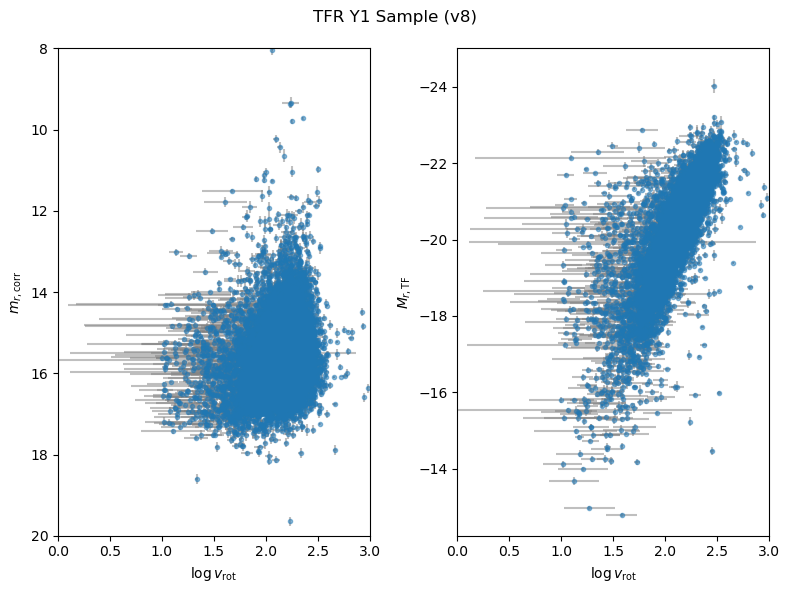

In [21]:
fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True)

ax = axes[0]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_MAG_SB26_CORR'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$m_{r,\mathrm{corr}}$',
       ylim=(20,8))

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{TF}}$',
       ylim=(-12.25, -25))

fig.suptitle('TFR Y1 Sample (v8)');
# fig.savefig('tfr_y1_sample.png', dpi=180);

### Generate Absolute Magnitudes for TFR Fitting

Procedure:
1. Calculate $M_{r,\mathrm{cos}}$ using $z_\mathrm{cos}$ from the mocks. This explicitly excludes mock peculiar velocities.
2. Compute $V_\mathrm{rot}$ using $M_{r,\mathrm{cos}}$ from the calibrated TFR relation in data, inverted and with uncertainties propagated.
3. Compute distance moduli $\mu$ for each *observed* redshift in the mocks, $z_\mathrm{obs}$.
4. Compute $M_{r,\mathrm{obs}}$ using $m_{r,\mathrm{SB26}}$ from cross-matched from data and the generated $\mu$.
5. Scatter $\log{V_\mathrm{rot}}$ by binning the Y1 data in magnitude, computing the $\log{v_\mathrm{rot}}$ CDF in each bin, and randomly sampling new values.

In [22]:
#- 1. distmod with cosmological redshifts to compute a "true" absolute magnitude M_r(SB26).
#  Then compute a central value for rotational velocity using this "true" magnitude.
Mr_cos = mock['R_MAG_SB26_CORR'] - cosmology.distmod(mock['zcos']).to_value('mag')

#- 2. Sample a, b for every Mr_cos and compute a scattered log_vrot.
a_k, b_k = np.random.multivariate_normal((a, b0pt), tf_cov[:2, :2], len(Mr_cos)).T
logvrot = ((Mr_cos - b_k) / a_k) + logV0

#- 3. Compute an observed magnitude based on the PVs in the mock catalog.
Mr_obs_mock = (mock['R_MAG_SB26_CORR'] - cosmology.distmod(mock['zobs']).to_value('mag')).to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

#- Bin R_ABSMAG_SB26. Merge any bins with < 50 datapoints, working from the ends of the magnitude range.
bins = np.arange(-26, -12 + 0.05, 0.05)
M_r_bins = [bins[0]]
for k in np.arange(1, len(bins)):
    select = (tfrcat['R_ABSMAG_SB26'] > M_r_bins[-1]) & (tfrcat['R_ABSMAG_SB26'] <= bins[k])    
    if np.sum(select) >= 50:
        M_r_bins.append(bins[k])
M_r_bins.append(bins[-1])
N_bins = len(M_r_bins)

print(np.histogram(tfrcat['R_ABSMAG_SB26'], M_r_bins))

#- Loop through the magnitude bins and regenerate log(v_rot) by resampling the data.
#  Try to reduce resampling effects by using a smoothed version of the CDF of log(v_rot).
logvrot_mock = np.array(logvrot)

for k in tqdm(np.arange(0, N_bins-1)):
    M_r_min, M_r_max = M_r_bins[k], M_r_bins[k+1]

    #- Select TFR velocity data in this magnitude bin and compute the CDF of log(v_rot).
    i = (tfrcat['R_ABSMAG_SB26'] > M_r_min) & (tfrcat['R_ABSMAG_SB26'] <= M_r_max)
    logvrot_slice = tfrcat['logv_rot'][i].to_numpy()
    logvrot_cdf = np.cumsum(logvrot_slice) / np.sum(logvrot_slice)

    #- Select mock data in this magnitude bin.
    j = (Mr_obs_mock > M_r_min) & (Mr_obs_mock <= M_r_max)
    N_mock_slice = np.sum(j)
    un = np.random.uniform(size=N_mock_slice)
    logvrot_mock_slice = csaps(logvrot_cdf, np.sort(logvrot_slice), un).values
    logvrot_mock[j] = logvrot_mock_slice

    #- Apply a velocity cut of 10 to 1000 km/s.
    #  Regenerate any velocities that fall outside the valid range.
    #  Note that an intermediate variable is needed to manage the array slicing.
    bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)
    while np.any(bad_vrot):
        N_regen = np.sum(bad_vrot)
        uni = np.random.uniform(size=N_regen)
        logvrot_mock_regen = logvrot_mock[j]
        logvrot_mock_regen[bad_vrot] = csaps(logvrot_cdf, np.sort(logvrot_slice), uni).values
        logvrot_mock[j] = logvrot_mock_regen
        bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)

# #- Next, scatter in the Mr_obs, logvrot plane using the sigma fit from the data,
# #  projected onto the best fit line in the TFR Y1 *data*. Use this projected sigma
# #  to scatter the mock Mr_obs vs logvrot.
# slope = np.asarray([-a, 1.])
# slope = slope / np.sqrt(np.dot(slope, slope))

# logging.warning('Using a fudge factor in sigma. Revisit!')
# scale = np.random.normal(0, 0.13*sigma, len(Mr_obs))
# logvrot_mock = logvrot + scale*slope[0]
# Mr_obs_mock = Mr_obs + scale*slope[1]

#- Finally, match mock values against the Y1 data to assign uncertainties on logvrot_mock and Mr_obs_mock.
#  Many ways to do this... here just copy the FP approach of grabbing the nearest neighbor in (log v, M_r)
#  from data and taking its uncertainty.
search_tree = KDTree(np.c_[tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26']])
search_tree.query([1.5, -20])
_, idx = search_tree.query([[x, y] for (x,y) in zip(logvrot_mock, Mr_obs_mock)])

logvrot_err_mock = tfrcat['logv_rot_err'][idx].to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

mock['LOGVROT_MOCK'] = logvrot_mock
mock['LOGVROT_ERR_MOCK'] = logvrot_err_mock
mock['R_ABSMAG_SB26_MOCK'] = Mr_obs_mock
mock['R_ABSMAG_SB26_ERR_MOCK'] = Mr_obs_err_mock

(array([ 51,  55,  77,  77,  54, 118,  58,  80,  77, 102, 120, 118, 128,
       146, 165, 150, 165, 159, 171, 169, 178, 204, 156, 213, 215, 189,
       177, 194, 180, 201, 172, 171, 184, 195, 178, 161, 174, 165, 166,
       162, 148, 151, 170, 150, 144, 136, 136, 136, 128, 101, 130, 114,
       101, 125,  96, 111,  89,  92,  98, 100,  90,  88,  87,  75,  59,
        69,  70,  61,  52,  55,  51,  53,  50,  67,  94,  52,  77,  85,
        62,  64,  67,  59,  52,  68,  57,  56,  53,  54,  52,  50,   3]), array([-26.  , -22.55, -22.4 , -22.25, -22.15, -22.1 , -22.  , -21.95,
       -21.9 , -21.85, -21.8 , -21.75, -21.7 , -21.65, -21.6 , -21.55,
       -21.5 , -21.45, -21.4 , -21.35, -21.3 , -21.25, -21.2 , -21.15,
       -21.1 , -21.05, -21.  , -20.95, -20.9 , -20.85, -20.8 , -20.75,
       -20.7 , -20.65, -20.6 , -20.55, -20.5 , -20.45, -20.4 , -20.35,
       -20.3 , -20.25, -20.2 , -20.15, -20.1 , -20.05, -20.  , -19.95,
       -19.9 , -19.85, -19.8 , -19.75, -19.7 , -19.65, -19.6 , -19.

100%|██████████| 91/91 [00:00<00:00, 299.00it/s]


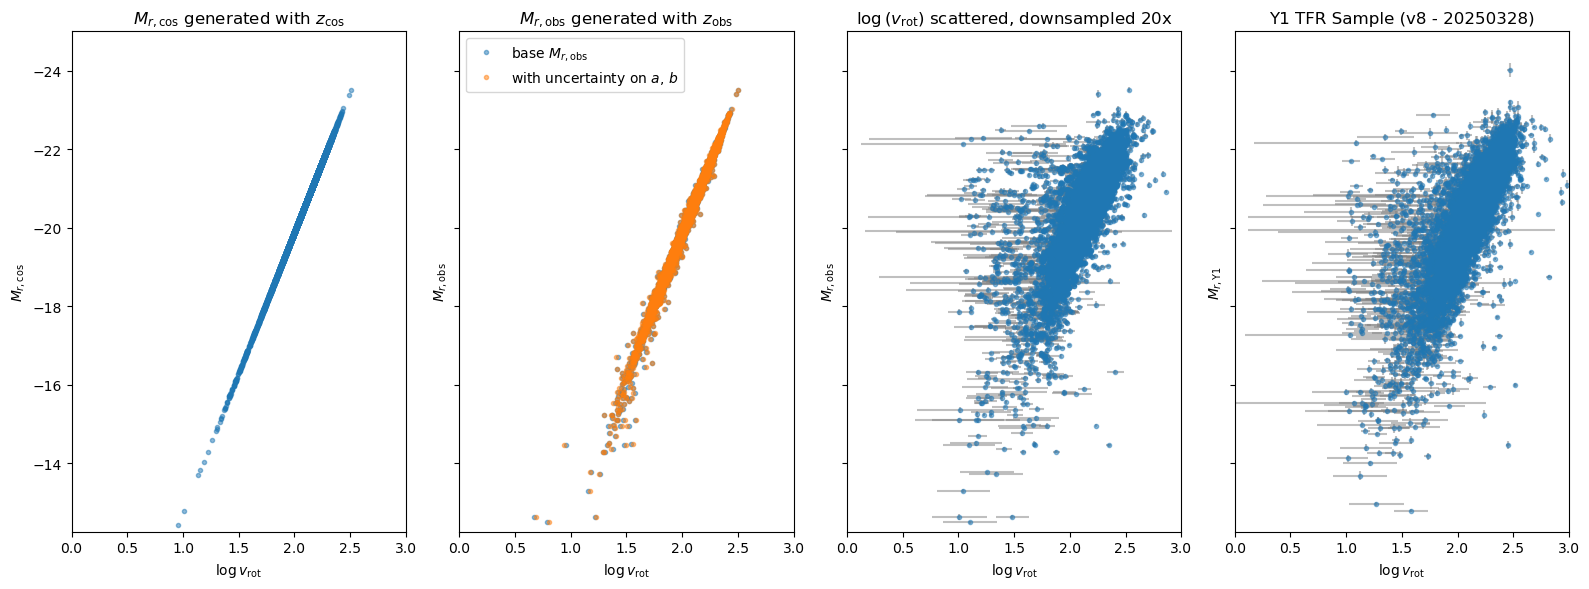

In [23]:
#- Plot Mr vs log(v_rot) for the various steps in the calculation.

fig, axes = plt.subplots(1,4, figsize=(16,6), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.errorbar((((Mr_cos - b0pt) / a) + logV0)[::20], Mr_cos[::20],
             # xerr=tfrcat['logv_rot_err'],
             # yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{cos}}$',
       ylim=(-12.25, -25),
       title=r'$M_{r,\mathrm{cos}}$ generated with $z_\mathrm{cos}$')

ax = axes[1]
ax.errorbar((((Mr_cos - b0pt) / a) + logV0)[::20], Mr_obs_mock[::20],
             # xerr=tfrcat['logv_rot_err'],
             # yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray',
             label=r'base $M_{r,\mathrm{obs}}$')

ax.errorbar(logvrot[::20], Mr_obs_mock[::20],
             # xerr=tfrcat['logv_rot_err'],
             # yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray',
             label=r'with uncertainty on $a$, $b$')

ax.legend(loc='upper left')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'$M_{r,\mathrm{obs}}$ generated with $z_\mathrm{obs}$')

ax = axes[2]
ax.errorbar(
            mock['LOGVROT_MOCK'][::20], mock['R_ABSMAG_SB26_MOCK'][::20],
            xerr=mock['LOGVROT_ERR_MOCK'][::20],
            yerr=mock['R_ABSMAG_SB26_ERR_MOCK'][::20],
            # logvrot_mock[::20], Mr_obs_mock[::20],
            # xerr=logvrot_err_mock[::20],
            # yerr=Mr_obs_err_mock[::20],
            fmt='.', 
            alpha=0.5, 
            ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'$\log{(v_\mathrm{rot})}$ scattered, downsampled 20x')

ax = axes[3]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{Y1}}$',
       ylim=(-12.25, -25),
       title='Y1 TFR Sample (v8 - 20250328)');

# fig.savefig('tfr_mock_mr_vs_logv.png', dpi=150);

### Compute the Maximum Volume for each Galaxy

Since the SGA is size-limited, with $D_{26}>0.2'$, there is a maximum volume within which the galaxy could be located to be included in the SGA. Calculate the maximum volume to be used as a weight in the TFR calibration.

In [24]:
dist = cosmology.luminosity_distance(np.abs(mock['zobs']))
dist_max = cosmology.luminosity_distance(z=0.1)
d26_kpc = 2*dist.to('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
mock_dist_max = 0.5*d26_kpc / np.tan(0.1*u.arcmin)
# surv_max = cosmology.luminosity_distance(z=0.2)

# mock['D26_kpc'] = 2*dist.to_value('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
# mock['DIST_MAX'] = 0.5*mock['D26_kpc'].values / np.tan(0.1*u.arcmin)
# mock['MAX_VOL_FRAC'] = (1e-3 * mock['DIST_MAX'].values)**3 / dist_max.to_value('Mpc')**3
mock['MAX_VOL_FRAC'] = mock_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3

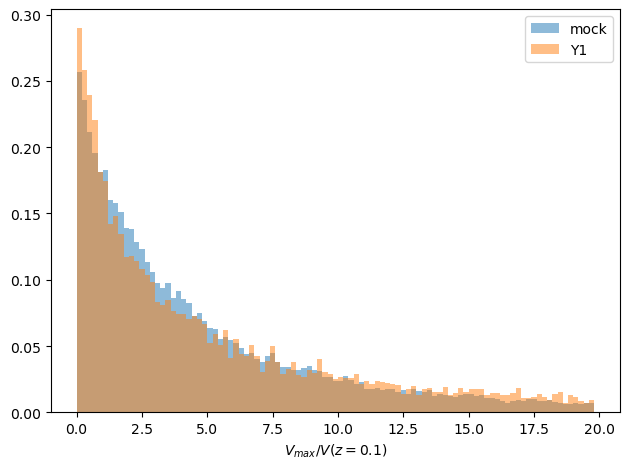

In [25]:
plt.figure(tight_layout=True)

iron_dist = cosmology.luminosity_distance(np.abs(tfrcat['Z_DESI'].values))
iron_d26kpc = 2*iron_dist.to('kpc') * np.tan(0.5*tfrcat['D26'].values*u.arcmin)
iron_dist_max = 0.5*iron_d26kpc / np.tan(0.1*u.arcmin)

plt.hist(mock['MAX_VOL_FRAC'], np.arange(0, 20, 0.2), density=True, alpha=0.5, label='mock')
plt.hist(iron_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3, np.arange(0, 20, 0.2), density=True, alpha=0.5, label='Y1')

plt.legend()

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

### Fit the TFR and Compute Mock Distance Moduli

Fit $M_{r,\mathrm{obs,mock}}$ versus $\log{V_\mathrm{rot,mock}}$ to get a mock TFR.

Then compute the TF distance modulus as

$$
\mu_\mathrm{mock} = m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{obs,mock}},
$$

where the apparent magnitude is the quantity `R_MAG_SB26_CORR` used to compute magnitudes from the cosmological and observed redshift.

#### Compute the volume weights and apply `LinFit` from `hyperfit`

In [26]:
#- Downsample by 1000x to get a zero-pointed "calibration fit" with statistics similar to Y1 (~150 to 200 galaxies).
N = len(logvrot_mock)
Ns = 150
idx = np.random.choice(N-1, size=Ns, replace=False)

In [41]:
logV0_mock = np.median(logvrot_mock)

logv  = logvrot_mock[idx] - logV0_mock
dlogv = logvrot_err_mock[idx]
Mr  = Mr_obs_mock[idx]
dMr = Mr_obs_err_mock[idx]
weights = np.ones_like(logv)
# weights = 1/mock['MAX_VOL_FRAC'].to_numpy()[idx]

mock_dat = np.empty((2, Ns))
mock_cov = np.empty((2, 2, Ns))

logv, Ns, len(logv)

for k in range(Ns):
    mock_dat[:, k] = np.array([logv[k], Mr[k]])
    mock_cov[:,:,k] = np.array([[dlogv[k]**2, 0.], [0., dMr[k]**2]])

bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)]                    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

# logging.warning('Fit does not account for volume weights.')

hf = LinFit(mock_dat, mock_cov, weights=weights)
(a_bf, b_bf), sigma_bf, ll_bf = hf.optimize(bounds, verbose=False)

print(f'a = {a_bf:.3f}')
print(f'b = {b_bf:.3f}')
print(f'sigma = {sigma_bf:.3f}')

mcmc_samples, mcmc_ll = hf.emcee(bounds, verbose=False)
bf = np.median(mcmc_samples, axis=1)
a_mcmc = bf[0]
b_mcmc = bf[1]
sigma_mcmc = bf[2]
cov_mcmc = np.cov(mcmc_samples)

print('\nMCMC output:')
print(f'a = {a_mcmc:.3f}')
print(f'b = {b_mcmc:.3f}')
print(f'sigma = {sigma_mcmc:.3f}')

a = -6.396
b = -20.595
sigma = 0.478

MCMC output:
a = -6.373
b = -20.596
sigma = 0.478


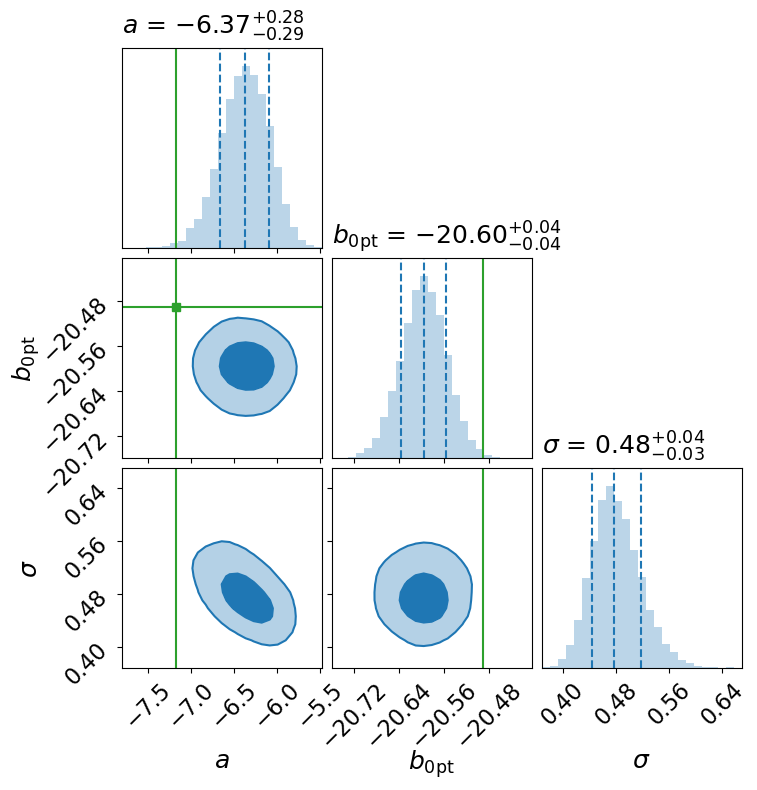

In [42]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$']
labels += [r'$\sigma$']

fig = corner(mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             truths=tf_par,
             truth_color='tab:green',
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16);

fig.savefig('tfr_mock_calibration_mcmc.png', dpi=150)

#### Dwarf Cut

In [43]:
#- Apply a dwarf cut using the TFR calibration
h = cosmology.H0.value/100
logV_n17 = (-17 + 5*np.log10(h) - b_mcmc)/a_mcmc + logV0_mock
b_perp = -17 + 5*np.log10(h) + (1/a_mcmc)*(logV_n17 - logV0_mock)
mock['DWARF'] = (mock['R_ABSMAG_SB26_MOCK'] - mock['R_ABSMAG_SB26_ERR_MOCK']) > (-(logvrot_mock - logV0_mock)/a_mcmc + b_perp)

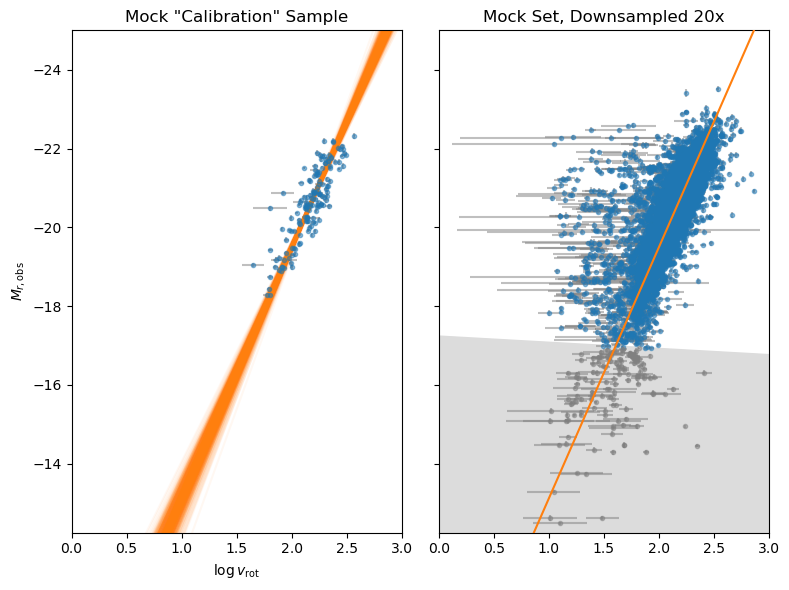

In [44]:
fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.errorbar(logvrot_mock[idx], Mr_obs_mock[idx],
             xerr=logvrot_err_mock[idx],
             yerr=Mr_obs_err_mock[idx],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

# _logv = np.arange(0, 3, 0.1) - logV0
_logv = np.arange(0, 3.1, 0.1)
for (_a, _b, _s) in mcmc_samples[:, ::100].T:
    ax.plot(_logv, _a*(_logv - logV0_mock) + _b, color='tab:orange', alpha=0.05)

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'Mock "Calibration" Sample')

ax = axes[1]
is_dwarf = mock['DWARF'][::20]
ax.errorbar(logvrot_mock[::20][~is_dwarf], Mr_obs_mock[::20][~is_dwarf],
            xerr=logvrot_err_mock[::20][~is_dwarf],
            yerr=Mr_obs_err_mock[::20][~is_dwarf],
            fmt='.', 
            alpha=0.5, 
            ecolor='gray')
ax.errorbar(logvrot_mock[::20][is_dwarf], Mr_obs_mock[::20][is_dwarf],
            xerr=logvrot_err_mock[::20][is_dwarf],
            yerr=Mr_obs_err_mock[::20][is_dwarf],
            fmt='.', 
            color='gray',
            alpha=0.5, 
            ecolor='gray')

ax.plot(_logv , a_mcmc*(_logv - logV0_mock) + b_mcmc, color='tab:orange', zorder=100)
ax.fill_between(_logv, -(_logv - logV0_mock)/a_mcmc + b_perp, -12, color='gainsboro')

ax.set(title='Mock Set, Downsampled 20x');
fig.savefig('tfr_mock_calibration_fit.png', dpi=150);

### Compute TFR Distance Modulus

Using the "measured" apparent magnitude and the TFR-predicted absolute magnitude from the "calibration" above, compute the distance modulus:

$$
\mu_\mathrm{TF} =  m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{TF}}.
$$

Also compute the log distance ratio

$$
\eta = \log{\left(\frac{D_z}{D_\mathrm{TFR}}\right)}
$$

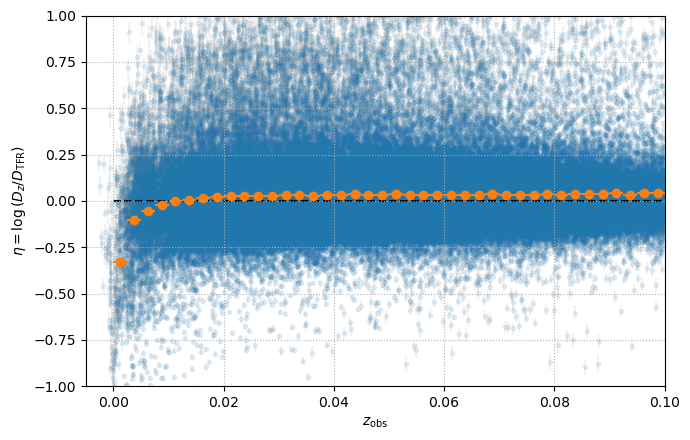

In [45]:
#- Compute TF absolute magnitude and uncertainties using the MCMC from HyperFit.
#  Downsample the MCMC significantly for this quick calculation.
Mr_TF = a_mcmc * (logvrot_mock - logV0_mock) + b_mcmc
a_sampled, b_sampled = mcmc_samples[0][::500], mcmc_samples[1][::500]
Mr_TF_err = np.std(a_sampled * (logvrot_mock[:, np.newaxis] - logV0_mock) + b_sampled, axis=1)

mu_TF = mock['R_MAG_SB26_CORR'] - Mr_TF
mu_TF_err = np.sqrt(mock['R_ABSMAG_SB26_ERR_MOCK']**2 + Mr_TF_err**2)

mu_zcmb = cosmology.distmod(mock['zobs']).to_value('mag')
mu_zcos = cosmology.distmod(mock['zcos']).to_value('mag')

eta_true = 0.2 * (mu_zcmb - mu_zcos)
eta_mock = 0.2 * (mu_zcmb - mu_TF)
eta_err_mock = 0.2 * mu_TF_err

fig, ax = plt.subplots(1,1, figsize=(7,4.5), tight_layout=True)
ax.errorbar(mock['zobs'], eta_mock,
            yerr=eta_err_mock,
            fmt='.',
            alpha=0.1,
            ecolor='gray', 
            zorder=0)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_mock, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', zorder=2)

ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed', zorder=1)
ax.grid(ls=':')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$');

# fig.savefig('tfr_mock_eta.png', dpi=150);

/tmp/ipykernel_55294/1790439695.py:1: RuntimeWarning: invalid value encountered in log10
  logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)


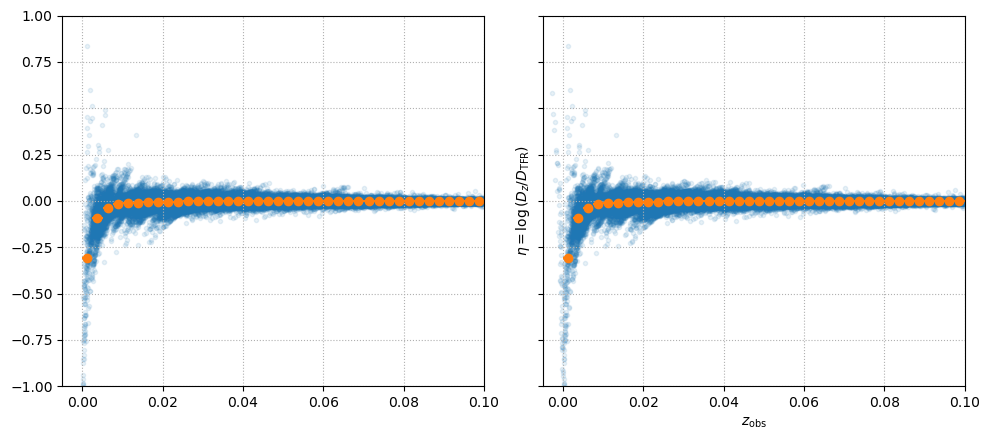

In [46]:
logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.scatter(mock['zobs'], logdist_true, marker='.', alpha=0.1)

ax = axes[1]
ax.scatter(mock['zobs'], eta_true, marker='.', alpha=0.1)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], logdist_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.grid(ls=':')

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

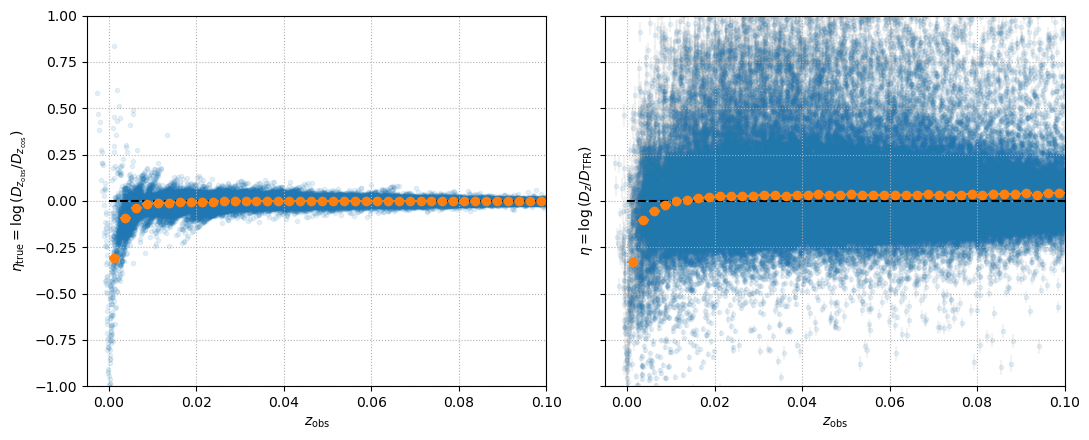

In [47]:
fig, axes = plt.subplots(1,2, figsize=(11,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.plot(mock['zobs'], eta_true, '.', alpha=0.1, zorder=0)

ax = axes[1]
ax.errorbar(mock['zobs'], eta_mock, yerr=eta_err_mock, fmt='.', alpha=0.1, ecolor='gray', zorder=0)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta_\mathrm{true} = \log{(D_{z_\mathrm{obs}} / D_{z_\mathrm{cos}})}$')
ax.grid(ls=':')

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_mock, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       ylim=(-1,1),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

fig.savefig('tfr_mock_eta_true_mock.png', dpi=150);

## Write Output to FITS

In [34]:
outfile = os.path.join('/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/fullmocks/v0.5',
                       os.path.basename(mockfile).replace('.dat.hdf5', '.fits').replace('BGS_PV', 'TF'))

hdr = fits.Header(dict(NTF=len(mock),
                       a=a_mcmc,
                       b=b_mcmc,
                       sigma=sigma_mcmc,
                       cov_aa=cov_mcmc[0][0],
                       cov_ab=cov_mcmc[0][1],
                       cov_as=cov_mcmc[0][2],
                       cov_bb=cov_mcmc[1][1],
                       cov_bs=cov_mcmc[1][2],
                       cov_ss=cov_mcmc[2][2]))

col01 = fits.Column(name='RA',            format='D', array=mock['ra'].to_numpy())
col02 = fits.Column(name='DEC',           format='D', array=mock['dec'].to_numpy())
col03 = fits.Column(name='ZOBS',          format='D', array=mock['zobs'].to_numpy())
col04 = fits.Column(name='ZCOS',          format='D', array=mock['zcos'].to_numpy())
col05 = fits.Column(name='vx',            format='D', array=mock['vx'].to_numpy())
col06 = fits.Column(name='vy',            format='D', array=mock['vy'].to_numpy())
col07 = fits.Column(name='vz',            format='D', array=mock['vz'].to_numpy())
col08 = fits.Column(name='DWARF',         format='L', array=mock['DWARF'].to_numpy())
col09 = fits.Column(name='LOGVROT',       format='D', array=mock['LOGVROT_MOCK'].to_numpy())
col10 = fits.Column(name='R_ABSMAG_SB26', format='D', array=mock['R_ABSMAG_SB26_MOCK'].to_numpy())
col11 = fits.Column(name='LOGDIST_TRUE',  format='D', array=eta_true)
col12 = fits.Column(name='LOGDIST',       format='D', array=eta_mock.to_numpy())
col13 = fits.Column(name='LOGDIST_ERR',   format='D', array=eta_err_mock.to_numpy())

hdulist = fits.BinTableHDU.from_columns([col01, col02, col03, col04, col05,
                                         col06, col07, col08, col09, col10,
                                         col11, col12, col13], header=hdr)
hdulist.writeto(outfile, overwrite=True)

shutil.chown(outfile, group='desi')